In [2]:
from pydub import AudioSegment
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from pydub import AudioSegment
from sklearn.model_selection import train_test_split

In [3]:
from tqdm import tqdm

In [4]:
import os
result = os.environ['PATH']
os.environ['PATH'] += os.pathsep + 'C:\\Program Files\\ffmpeg-2024-09-22-git-a577d313b2-full_build\\bin'

In [5]:
path_to_jayesh_drinking = "DrinkingAudio\\JayeshDrinking\\DrinkRecording"
path_to_jayesh_not_drinking = "DrinkingAudio\\JayeshDrinking\\SilentRecording\\"
path_to_elvis_drinking = "DrinkingAudio\\ElvisDrinking\\DrinkRecording\\"
path_to_elvis_not_drinking = "DrinkingAudio\\ElvisDrinking\\SilentRecording\\"

In [22]:
# load jayesh m4a files 
jayesh_drinking_files = [f for f in os.listdir(path_to_jayesh_drinking) if f.endswith('.m4a')]
jayesh_not_drinking_files = [f for f in os.listdir(path_to_jayesh_not_drinking) if f.endswith('.m4a')]

# load elvis mp4 files
elvis_drinking_files = [f for f in os.listdir(path_to_elvis_drinking) if f.endswith('.mp4')]
elvis_not_drinking_files = [f for f in os.listdir(path_to_elvis_not_drinking) if f.endswith('.mp4')]

In [23]:
# Function to load audio file
def load_audio_file(file_path):
    audio = AudioSegment.from_file(file_path)
    audio = audio.set_frame_rate(16000)
    return audio

# Load audio files and store in dictionaries
jayesh_drinking_waveforms = {f: load_audio_file(os.path.join(path_to_jayesh_drinking, f)) for f in jayesh_drinking_files}
jayesh_not_drinking_waveforms = {f: load_audio_file(os.path.join(path_to_jayesh_not_drinking, f)) for f in jayesh_not_drinking_files}
elvis_drinking_waveforms = {f: load_audio_file(os.path.join(path_to_elvis_drinking, f)) for f in elvis_drinking_files}
elvis_not_drinking_waveforms = {f: load_audio_file(os.path.join(path_to_elvis_not_drinking, f)) for f in elvis_not_drinking_files}


In [24]:
# print length of each list 
print(len(jayesh_drinking_waveforms))
print(len(jayesh_not_drinking_waveforms))
print(len(elvis_drinking_waveforms))
print(len(elvis_not_drinking_waveforms))

0
26
110
179


In [25]:
# load csv files for jayesh and elvis
# jayesh_drinking_csv = pd.read_csv("DrinkingAudio\\JayeshDrinking\\Csv\\GulpTimeElvis.csv")
elvis_drinking_csv = pd.read_csv("DrinkingAudio\\ElvisDrinking\\Csv\\GulpTimeElvis.csv")

In [26]:
elvis_drinking_csv.head()

,SampleName,SampleVolume,StartTime,GulpTimes,EndTime
0,ncs_water_bottle_0_elvis_100,112,00:05:41,00:07:39_00:09:06_00:10:62_00:12:14_00:13:81_0...,00:20:27
1,ncs_water_bottle_0_elvis_101,96,00:05:07,00:06:90_00:08:51_00:10:08_00:11:65_00:13:52_0...,00:18:02
2,ncs_water_bottle_0_elvis_102,93,00:02:42,00:04:50_00:06:27_00:07:93_00:09:60_00:11:37_0...,00:16:24
3,ncs_water_bottle_0_elvis_103,64,00:03:18,00:05:31_00:07:04_00:08:66_00:10:18_00:11:81_,00:12:77
4,ncs_water_bottle_0_elvis_104,86,00:04:00,00:05:77_00:07:49_00:09:32_00:11:25_00:13:18_0...,00:16:48


In [27]:
# remove .mp4 and .m4a from each key in the dictionary depending on what it has
jayesh_drinking_waveforms = {k.replace('.m4a', ''): v for k, v in jayesh_drinking_waveforms.items()}
jayesh_not_drinking_waveforms = {k.replace('.m4a', ''): v for k, v in jayesh_not_drinking_waveforms.items()}
elvis_drinking_waveforms = {k.replace('.mp4', ''): v for k, v in elvis_drinking_waveforms.items()}
elvis_not_drinking_waveforms = {k.replace('.mp4', ''): v for k, v in elvis_not_drinking_waveforms.items()}

In [28]:
# length of a waveform 
elvis_drinking_waveforms['ncs_water_bottle_0_elvis_100'].duration_seconds

23.684375

In [29]:
# add duration to the df based on the key from elvis_drinking_waveforms
elvis_drinking_csv['duration'] = elvis_drinking_csv['SampleName'].apply(lambda x: elvis_drinking_waveforms[x].duration_seconds)

In [30]:
elvis_drinking_csv.head()

,SampleName,SampleVolume,StartTime,GulpTimes,EndTime,duration
0,ncs_water_bottle_0_elvis_100,112,00:05:41,00:07:39_00:09:06_00:10:62_00:12:14_00:13:81_0...,00:20:27,23.684375
1,ncs_water_bottle_0_elvis_101,96,00:05:07,00:06:90_00:08:51_00:10:08_00:11:65_00:13:52_0...,00:18:02,21.339125
2,ncs_water_bottle_0_elvis_102,93,00:02:42,00:04:50_00:06:27_00:07:93_00:09:60_00:11:37_0...,00:16:24,18.622438
3,ncs_water_bottle_0_elvis_103,64,00:03:18,00:05:31_00:07:04_00:08:66_00:10:18_00:11:81_,00:12:77,15.487687
4,ncs_water_bottle_0_elvis_104,86,00:04:00,00:05:77_00:07:49_00:09:32_00:11:25_00:13:18_0...,00:16:48,19.481562


In [31]:
elvis_drinking_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SampleName    110 non-null    object 
 1   SampleVolume  110 non-null    int64  
 2   StartTime     110 non-null    object 
 3   GulpTimes     110 non-null    object 
 4   EndTime       110 non-null    object 
 5   duration      110 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 5.3+ KB


In [32]:
# sum of SampleVolume
elvis_drinking_csv['SampleVolume'].sum()

7710

In [35]:
# sum of duration of all waveforms in the dictionary
a = sum([v.duration_seconds for v in elvis_drinking_waveforms.values()])
b = sum([v.duration_seconds for v in jayesh_drinking_waveforms.values()])
c = sum([v.duration_seconds for v in jayesh_not_drinking_waveforms.values()])
d = sum([v.duration_seconds for v in elvis_not_drinking_waveforms.values()])

In [36]:
# sum of all waveforms
a

1582.7893749999992

In [37]:
a + b + c + d

8478.1913125

In [38]:
# combine the drinking and not drinking waveforms
drinking_waveforms = {**jayesh_drinking_waveforms, **elvis_drinking_waveforms}
not_drinking_waveforms = {**jayesh_not_drinking_waveforms, **elvis_not_drinking_waveforms}

In [ ]:
drinking_waveforms

In [39]:
def augment_audio(audio, augment_type="pitch_shift"):
    samples = np.array(audio.get_array_of_samples())
    
    if augment_type == "pitch_shift":
        # Pitch shifting
        n_steps = random.randint(-6, 6)  # Shift pitch by up to 2 steps
        shifted = librosa.effects.pitch_shift(samples.astype(float), sr=audio.frame_rate, n_steps=n_steps)
        return AudioSegment(
            shifted.astype(np.int16).tobytes(), 
            frame_rate=audio.frame_rate, 
            sample_width=audio.sample_width,
            channels=audio.channels
        )
    elif augment_type == "add_noise":
        # Adding noise
        noise = np.random.normal(0, 0.20, len(samples))  # Adjust the noise level as needed
        noisy = samples + noise
        return AudioSegment(
            noisy.astype(np.int16).tobytes(), 
            frame_rate=audio.frame_rate, 
            sample_width=audio.sample_width,
            channels=audio.channels
        )
    elif augment_type == "volume_adjust":
        # Adjusting volume
        volume_change = random.uniform(-10, 15)  # Change volume by -5 to +5 dB
        return audio + volume_change  # Adjust volume
    else:
        return audio  # No augmentation

In [41]:
# Assuming original_data is a dictionary with file names as keys and AudioSegment objects as values
augmented_data_drinking = {}

for sample_name, audio in tqdm(drinking_waveforms.items()):  # Loop through the original dataset
    for i in range(3):  # Create 3 augmented versions
        augment_type = random.choice(["pitch_shift", "add_noise", "volume_adjust"])  # Randomly select augmentation
        augmented_audio = augment_audio(audio, augment_type=augment_type)
        augmented_data_drinking[f"{sample_name}_aug{i}"] = augmented_audio


100%|██████████| 110/110 [00:26<00:00,  4.09it/s]


In [44]:
augmented_data_non_drinking = {}

for sample_name, audio in tqdm(not_drinking_waveforms.items()):  # Loop through the original dataset
    for i in range(3):  # Create 3 augmented versions
        augment_type = random.choice(["pitch_shift", "add_noise", "volume_adjust"])  # Randomly select augmentation
        augmented_audio = augment_audio(audio, augment_type=augment_type)
        augmented_data_non_drinking[f"{sample_name}_aug{i}"] = augmented_audio
        

100%|██████████| 205/205 [01:32<00:00,  2.21it/s]


In [33]:
def generate_white_noise(duration_ms, amplitude=0.5):
    """
    Generate white noise of specified duration and amplitude.
    """
    sample_rate = 16000  # Standard audio sample rate
    num_samples = int(sample_rate * (duration_ms / 1000.0))  # Total samples based on duration
    noise = np.random.normal(0, amplitude, num_samples).astype(np.float32)  # Generate random values
    
    # Convert to an AudioSegment
    noise_audio = AudioSegment(
        (noise * 32767).astype(np.int16).tobytes(),  # Scale and convert to 16-bit PCM
        frame_rate=sample_rate,
        sample_width=2,  # 16-bit samples = 2 bytes
        channels=1  # Mono
    )
    return noise_audio

def generate_pink_noise(duration_ms, amplitude=0.5):
    """
    Generate pink noise of specified duration and amplitude.
    """
    sample_rate = 16000
    num_samples = int(sample_rate * (duration_ms / 1000.0))
    uneven = num_samples % 2
    random_array = np.random.randn(num_samples // 2 + 1 + uneven) + 1j * np.random.randn(num_samples // 2 + 1 + uneven)
    s = np.abs(np.fft.rfft(random_array))**(-1)  # Create pink noise in the frequency domain
    s = np.fft.irfft(s, n=num_samples).real
    pink_noise = np.interp(s, (s.min(), s.max()), (-amplitude, amplitude))  # Normalize
    
    # Convert to an AudioSegment
    pink_audio = AudioSegment(
        (pink_noise * 32767).astype(np.int16).tobytes(),
        frame_rate=sample_rate,
        sample_width=2,
        channels=1
    )
    return pink_audio

def generate_random_noise(duration_ms):
    noise_type = random.choice(["white", "pink"])
    if noise_type == "white":
        return generate_white_noise(duration_ms)
    elif noise_type == "pink":
        return generate_pink_noise(duration_ms)

In [ ]:
def generate_random_noise(duration_ms):
    # Generate a noise segment of the specified duration
    return AudioSegment.silent(duration=duration_ms)  # Replace with actual noise if available


In [50]:
# Combine and shuffle the two dictionaries
all_data = list(augmented_data_drinking.items()) + list(augmented_data_non_drinking.items())
random.shuffle(all_data)  # Randomly shuffle drinking and non-drinking samples

final_audio = AudioSegment.empty()
event_tracker = []  # Will store start and end times of each drinking event in final_audio

current_position = 0  # Track the current position in the final_audio

for sample_name, audio in tqdm(all_data):
    # Check if the sample is from the drinking dataset
    if sample_name in augmented_data_drinking:
        # Retrieve metadata for drinking events
        row = elvis_drinking_csv[elvis_drinking_csv['SampleName'] == sample_name.split('_aug')[0]].iloc[0]  # Assuming csv_data is a DataFrame
        
        # Retrieve start and end times for drinking within this sample
        start_time_components = row['StartTime'].split(":")
        end_time_components = row['EndTime'].split(":")
        start_time_ms = int(start_time_components[1]) * 1000 + int(start_time_components[2])  # Convert StartTime to ms
        end_time_ms = int(end_time_components[1]) * 1000 + int(end_time_components[2])  # Convert EndTime to ms
        
        # Add drinking event to tracker with current position in final audio
        event_tracker.append({
            "start": current_position + start_time_ms,
            "end": current_position + end_time_ms,
            "sample_name": sample_name
        })
    
    # Append the sample to final_audio
    final_audio += audio
    current_position += len(audio)
    
    # Add random noise between samples
    if random.random() < 0.85:  # Add noise between 80% of the samples
        noise_duration_ms = random.randint(6000, 18000)  # Noise duration: 1 min to 3 min
        noise_segment = generate_random_noise(noise_duration_ms)
        final_audio += noise_segment
        current_position += noise_duration_ms



  0%|          | 0/945 [00:00<?, ?it/s]c:\Users\Jayesh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
100%|██████████| 945/945 [10:18<00:00,  1.53it/s]


In [51]:
# Save the final audio file
final_audio.export("final_audio_with_drinking_events.wav", format="wav")

# Save the event tracker
import pandas as pd

event_df = pd.DataFrame(event_tracker)
event_df.to_csv("drinking_event_times.csv", index=False)

In [53]:
event_df

,start,end,sample_name
0,1041,10016,library_water_bottle_0_elvis_162_aug2
1,196518,206521,home_water_bottle_0_elvis_111_aug1
2,408802,419868,library_water_bottle_0_elvis_152_aug1
3,439012,450013,library_water_bottle_0_elvis_206_aug1
4,535584,546568,home_water_bottle_0_elvis_179_aug2
...,...,...,...
324,34362056,34368023,home_water_bottle_0_elvis_190_aug2
325,34464952,34475896,home_water_bottle_0_elvis_127_aug2
326,34513573,34521615,library_water_bottle_0_elvis_201_aug1
327,34728409,34738423,home_water_bottle_0_elvis_119_aug2


In [6]:
# read the final audio file and the event tracker
final_audio = AudioSegment.from_file("final_audio_with_drinking_events.wav")
event_df = pd.read_csv("drinking_event_times.csv")

In [7]:
event_df['start_minute'] = event_df['start'] // 60000
event_df['end_minute'] = event_df['end'] // 60000

In [8]:
rows = []

for _, row in event_df.iterrows():
    for minute in range(row['start_minute'], row['end_minute'] + 1):
        rows.append({"minute": minute, "water_drinking": 1})

# Create a DataFrame from rows and fill in missing minutes
drinking_df = pd.DataFrame(rows).drop_duplicates()

# Fill in missing minutes with water_drinking = 0
all_minutes = range(drinking_df['minute'].min(), drinking_df['minute'].max() + 1)
all_minutes_df = pd.DataFrame({"minute": all_minutes})
final_df = all_minutes_df.merge(drinking_df, on="minute", how="left")
final_df['water_drinking'] = final_df['water_drinking'].fillna(0).astype(int)


In [29]:
final_df

,minute,water_drinking
0,0,1
1,1,0
2,2,0
3,3,1
4,4,0
...,...,...
581,581,0
582,582,1
583,583,1
584,574,0


In [21]:
# count 0s and 1s
final_df['water_drinking'].value_counts()

water_drinking
0    1803
1     530
Name: count, dtype: int64

In [20]:
final_audio.duration_seconds

35096.9605625

In [12]:
# append noise to round off to the nearest minute
noise_duration_ms = 60000 - (final_audio.duration_seconds * 1000) % 60000

In [13]:
noise_duration_ms

3039.4375

In [16]:
(final_audio.duration_seconds + noise_duration_ms/1000)/60

585.0

In [31]:
final_df.tail()

,minute,water_drinking
579,579,0
580,580,1
581,581,0
582,582,1
583,583,1


In [34]:
# add noise to the final audio
final_audio += generate_random_noise(noise_duration_ms)

c:\Users\Jayesh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


In [35]:
final_audio.duration_seconds

35100.0

In [36]:
# save the final audio
final_audio.export("final_audio_with_drinking_events.wav", format="wav")

<_io.BufferedRandom name='final_audio_with_drinking_events.wav'>

In [37]:
# add a row to the final_df for 584th minute using pd concat
final_df = pd.concat([final_df, pd.DataFrame({"minute": [584], "water_drinking": [0]})], ignore_index=True)

In [38]:
final_df.tail()

,minute,water_drinking
580,580,1
581,581,0
582,582,1
583,583,1
584,584,0


In [40]:
# duration of the drinking event in the event_df, subtract and divide by 1000 to get seconds
event_df['duration'] = (event_df['end'] - event_df['start']) / 1000

In [42]:
# sum of the duration of the drinking events
event_df['duration'].sum()

3224.595

(array([ 6., 21.,  3., 12.,  3., 33.,  3., 57., 15., 42., 15., 42., 18.,
        18., 12.,  9.,  0., 12.,  0.,  9.]),
 array([ 5.067  ,  5.56295,  6.0589 ,  6.55485,  7.0508 ,  7.54675,
         8.0427 ,  8.53865,  9.0346 ,  9.53055, 10.0265 , 10.52245,
        11.0184 , 11.51435, 12.0103 , 12.50625, 13.0022 , 13.49815,
        13.9941 , 14.49005, 14.986  ]),
 <BarContainer object of 20 artists>)

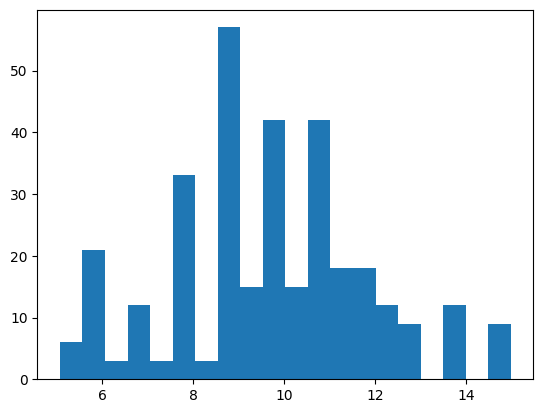

In [43]:
# plot the duration of the drinking events
plt.hist(event_df['duration'], bins=20)

In [44]:
# find mean and std of the duration of the drinking events
event_df['duration'].mean(), event_df['duration'].std()

(9.7715, 2.15600444683494)

In [45]:
def split_and_label_audio(audio, final_df, sr=16000):
    labeled_segments = []

    for idx, row in final_df.iterrows():
        start_time = row['minute'] * 60 * 1000  # Convert minutes to milliseconds
        end_time = start_time + 60 * 1000  # 1 minute later
        segment = audio[start_time:end_time]
        
        label = row['water_drinking']  # 1 for drinking, 0 for not drinking
        labeled_segments.append((segment, label))
    
    return labeled_segments

In [46]:
def extract_mfcc(audio_segment, sr=16000, n_mfcc=13):
    samples = np.array(audio_segment.get_array_of_samples()).astype(np.float32) / 32768.0
    mfcc = librosa.feature.mfcc(y=samples, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # Transpose to (time, n_mfcc)

In [47]:
audio_segments = split_and_label_audio(final_audio, final_df)

all_mfccs = []
all_labels = []

for segment, label in tqdm(audio_segments):
    mfcc = extract_mfcc(segment)
    all_mfccs.append(mfcc)
    all_labels.append(label)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_mfccs, all_labels, test_size=0.25, random_state=42, stratify=all_labels)


100%|██████████| 585/585 [01:02<00:00,  9.37it/s]


In [50]:
len(X_train), len(X_test)

(438, 147)

In [48]:
from torch.utils.data import Dataset, DataLoader
import torch

class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        mfcc = self.X[idx]
        label = self.y[idx]
        mfcc = np.expand_dims(mfcc, axis=0)  # Add channel dimension
        return torch.tensor(mfcc, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [87]:
train_dataset[0][0].shape

torch.Size([1, 1876, 13])

In [68]:
# Define the CNN model
class AudioClassifierCNN(nn.Module):
    def __init__(self):
        super(AudioClassifierCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Initialize the fully connected layer size dynamically
        self.fc1 = nn.Linear(self._get_conv_output_size(), 128)
        self.fc2 = nn.Linear(128, 2)  # Assuming binary classification

    def _get_conv_output_size(self):
        # Create a dummy input to calculate the size after convolution layers
        dummy_input = torch.zeros(1, 1, 3751, 13)  # Sample input shape
        x = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return int(torch.prod(torch.tensor(x.size()[1:])))

    def forward(self, x):
        # Apply convolutional layers with ReLU activations and max pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the input dynamically
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation for output (CrossEntropyLoss will be applied later)

        return x


# Create the model instance
model = AudioClassifierCNN()


In [69]:
# Define loss function (Cross-Entropy Loss for classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/25], Loss: 5.3207, Accuracy: 54.11%
Epoch [2/25], Loss: 1.1060, Accuracy: 53.88%
Epoch [3/25], Loss: 0.7270, Accuracy: 55.71%
Epoch [4/25], Loss: 0.6679, Accuracy: 62.56%
Epoch [5/25], Loss: 0.6048, Accuracy: 66.21%
Epoch [6/25], Loss: 0.5897, Accuracy: 69.63%
Epoch [7/25], Loss: 0.5407, Accuracy: 73.06%
Epoch [8/25], Loss: 0.6048, Accuracy: 67.81%
Epoch [9/25], Loss: 0.5310, Accuracy: 71.00%
Epoch [10/25], Loss: 0.4725, Accuracy: 76.71%
Epoch [11/25], Loss: 0.5000, Accuracy: 74.43%
Epoch [12/25], Loss: 0.4678, Accuracy: 78.08%
Epoch [13/25], Loss: 0.3908, Accuracy: 82.42%
Epoch [14/25], Loss: 0.3744, Accuracy: 81.96%
Epoch [15/25], Loss: 0.3222, Accuracy: 86.53%
Epoch [16/25], Loss: 0.2594, Accuracy: 90.41%
Epoch [17/25], Loss: 0.2766, Accuracy: 89.50%
Epoch [18/25], Loss: 0.2612, Accuracy: 88.36%
Epoch [19/25], Loss: 0.1997, Accuracy: 91.55%
Epoch [20/25], Loss: 0.1448, Accuracy: 94.75%
Epoch [21/25], Loss: 0.1053, Accuracy: 97.72%
Epoch [22/25], Loss: 0.0665, Accuracy: 99.0

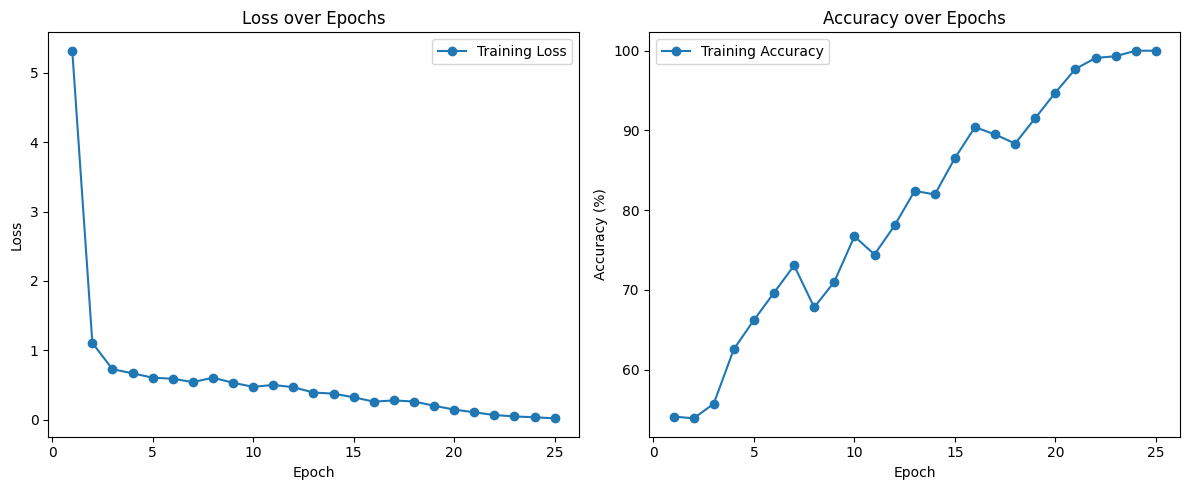

In [70]:
# Number of epochs and batch size
num_epochs = 25

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lists to store the loss and accuracy values for plotting
train_loss_history = []
train_accuracy_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Compute loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # Store the values for plotting
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)
    
    # Print epoch stats
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Plotting the Loss and Accuracy over epochs
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_history, marker='o', label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy_history, marker='o', label='Training Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [71]:
# Initialize empty lists to store true and predicted labels
all_labels = []
all_predictions = []

model.eval()  # Set model to evaluation mode (no gradients)
correct = 0
total = 0

with torch.no_grad():  # No need to compute gradients
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Accumulate total correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and true labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute test accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 49.65986394557823%
Confusion Matrix:
[[35 38]
 [36 38]]


In [7]:
# Calculate half-minute intervals
event_df['start_onefourth_minute'] = event_df['start'] // 15000
event_df['end_onefourth_minute'] = event_df['end'] // 15000

In [140]:
# rows = []

# for _, row in event_df.iterrows():
#     for half_minute in range(row['start_half_minute'], row['end_half_minute'] + 1):
#         rows.append({"half_minute": half_minute, "water_drinking": 1})

# # Create a DataFrame from rows and fill in missing half-minute intervals
# drinking_df = pd.DataFrame(rows).drop_duplicates()

# # Fill in missing half-minute intervals with water_drinking = 0
# all_half_minutes = range(drinking_df['half_minute'].min(), drinking_df['half_minute'].max() + 1)
# all_half_minutes_df = pd.DataFrame({"half_minute": all_half_minutes})
# final_df = all_half_minutes_df.merge(drinking_df, on="half_minute", how="left")
# final_df['water_drinking'] = final_df['water_drinking'].fillna(0).astype(int)

In [8]:
rows = []

for _, row in event_df.iterrows():
    for onefourth_minute in range(row['start_onefourth_minute'], row['end_onefourth_minute'] + 1):
        rows.append({"onefourth_minute": onefourth_minute, "water_drinking": 1})

# Create a DataFrame from rows and remove duplicates
drinking_df = pd.DataFrame(rows).drop_duplicates()

# Fill in missing quarter-minute intervals with water_drinking = 0
all_onefourth_minutes = range(drinking_df['onefourth_minute'].min(), drinking_df['onefourth_minute'].max() + 1)
all_onefourth_minutes_df = pd.DataFrame({"onefourth_minute": all_onefourth_minutes})
final_df = all_onefourth_minutes_df.merge(drinking_df, on="onefourth_minute", how="left")
final_df['water_drinking'] = final_df['water_drinking'].fillna(0).astype(int)

In [9]:
final_df.head()

,onefourth_minute,water_drinking
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0


In [79]:
def split_and_label_audio(audio, final_df, sr=16000):
    labeled_segments = []

    for idx, row in final_df.iterrows():
        # Convert half-minutes to milliseconds
        start_time = row['half_minute'] * 30 * 1000  
        end_time = start_time + 30 * 1000  # 30 seconds later
        segment = audio[start_time:end_time]
        
        label = row['water_drinking']  # 1 for drinking, 0 for not drinking
        labeled_segments.append((segment, label))
    
    return labeled_segments

In [11]:
def split_and_label_audio(audio, final_df, sr=16000, window_size=45, overlap=15):
    labeled_segments = []
    step = window_size - overlap  # Compute step size based on overlap

    for i, row in final_df.iterrows():
        start_time = row['half_minute'] * 30 * 1000  # Convert to milliseconds
        while start_time < (row['half_minute'] + 1) * 30 * 1000:
            end_time = start_time + window_size * 1000
            segment = audio[start_time:end_time]
            label = row['water_drinking']
            labeled_segments.append((segment, label))
            start_time += step * 1000  # Move to the next overlapping window

    return labeled_segments

In [49]:
def split_and_label_audio(audio, final_df, sr=16000, window_size=30, overlap=15):
    labeled_segments = []
    step = window_size - overlap  # Compute step size based on overlap
    
    for idx, row in final_df.iterrows():
        # Convert 'onefourth_minute' to milliseconds
        start_time = row['onefourth_minute'] * 15 * 1000  # Convert quarter minute to milliseconds
        end_time = start_time + window_size * 1000         # 30 seconds later
        
        # Check if the drinking event is in the current row or the next row
        if row['water_drinking'] == 1:
            label = 1
        elif idx + 1 < len(final_df) and final_df.iloc[idx + 1]['water_drinking'] == 1:
            label = 1
        else:
            label = 0
        
        # Extract the audio segment based on calculated start and end times
        segment = audio[start_time:end_time]
        
        # Append the segment and its label
        labeled_segments.append((segment, label))
        
        # Move to the next window with overlap
        start_time += step * 1000  # Move by step size in milliseconds
        end_time = start_time + window_size * 1000  # Update end time

    return labeled_segments

In [47]:
def split_and_label_audio(audio, final_df, sr=16000, window_size=45, overlap=15):
    labeled_segments = []
    step = window_size - overlap  # Compute step size based on overlap
    
    start_time = 0  # Start time in milliseconds
    while start_time < audio.duration_seconds*1000:  # Ensure we don't exceed the audio length
        end_time = start_time + window_size * 1000  # Calculate end time in milliseconds
        
        # Check if the current window overlaps with any drinking event
        label = 0
        for _, row in final_df.iterrows():
            event_start = row['onefourth_minute'] * 15 * 1000
            event_end = event_start + 15 * 1000  # Each onefourth_minute is 15 seconds
            if event_start < end_time and event_end > start_time:  # Overlap condition
                label = max(label, row['water_drinking'])  # Set label to 1 if any overlap
        
        # Extract the audio segment
        if start_time - end_time == 45000:
            print("YES")
            segment = audio[int(start_time):int(end_time)]
            labeled_segments.append((segment, label))
        
        # Move to the next window with the specified step
        start_time += step * 1000  # Increment start time by step size
        print(start_time, end_time)
    return labeled_segments

In [50]:
def extract_mfcc(audio_segment, sr=16000, n_mfcc=13):
    samples = np.array(audio_segment.get_array_of_samples()).astype(np.float32) / 32768.0
    mfcc = librosa.feature.mfcc(y=samples, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # Transpose to (time, n_mfcc)


In [51]:
audio_segments = split_and_label_audio(final_audio, final_df)

all_mfccs = []
all_labels = []

for segment, label in tqdm(audio_segments):
    mfcc = extract_mfcc(segment)
    all_mfccs.append(mfcc)
    all_labels.append(label)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_mfccs, all_labels, test_size=0.25, random_state=42, stratify=all_labels)

100%|██████████| 2333/2333 [02:52<00:00, 13.50it/s]


In [64]:
len(X_train), len(X_test)

(1749, 584)

In [65]:
from torch.utils.data import Dataset, DataLoader
import torch

class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        mfcc = self.X[idx]
        label = self.y[idx]
        mfcc = np.expand_dims(mfcc, axis=0)  # Add channel dimension
        return torch.tensor(mfcc, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [66]:
train_dataset[0][0].shape

torch.Size([1, 1876, 13])

In [58]:
class DeepAudioClassifierCNN(nn.Module):
    def __init__(self):
        super(DeepAudioClassifierCNN, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.3)  # Regularization
        
        # Second Convolutional Block with Residual Connection
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv1x1_1 = nn.Conv2d(32, 64, kernel_size=1)  # Match residual channels
        self.dropout2 = nn.Dropout2d(0.3)
        
        # Third Convolutional Block with Residual Connection
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv1x1_2 = nn.Conv2d(64, 128, kernel_size=1)  # Match residual channels
        self.dropout3 = nn.Dropout2d(0.3)

        # Fully Connected Layers
        self.fc1 = nn.Linear(self._get_conv_output_size(), 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)  # Binary classification

    def _get_conv_output_size(self):
        # Create a dummy input to calculate the size after convolution layers
        dummy_input = torch.zeros(1, 1, 1876, 13)  # Adjust according to your MFCC input
        x = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Apply until last conv layer
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        return int(torch.prod(torch.tensor(x.size()[1:])))
    
    def forward(self, x):
        # First Convolutional Block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        # Second Convolutional Block with Residual Connection
        residual = self.conv1x1_1(x)  # Adjust residual channels to match conv output
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x + residual  # Replace in-place addition
        x = self.pool(x)
        x = self.dropout2(x)

        # Third Convolutional Block with Residual Connection
        residual = self.conv1x1_2(x)  # Adjust residual channels to match conv output
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = x + residual  # Replace in-place addition
        x = self.pool(x)
        x = self.dropout3(x)

        # Flatten for Fully Connected Layers
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for output, use CrossEntropyLoss

        return x

# Create the model instance
model = DeepAudioClassifierCNN()


In [59]:
# Define loss function (Cross-Entropy Loss for classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/30], Loss: 1.3557, Accuracy: 62.04%
Epoch [2/30], Loss: 0.6267, Accuracy: 67.41%
Epoch [3/30], Loss: 0.5707, Accuracy: 70.67%
Epoch [4/30], Loss: 0.5183, Accuracy: 74.96%
Epoch [5/30], Loss: 0.5085, Accuracy: 75.99%
Epoch [6/30], Loss: 0.4794, Accuracy: 76.84%
Epoch [7/30], Loss: 0.4422, Accuracy: 79.82%
Epoch [8/30], Loss: 0.4501, Accuracy: 80.33%
Epoch [9/30], Loss: 0.4151, Accuracy: 80.73%
Epoch [10/30], Loss: 0.4221, Accuracy: 81.02%
Epoch [11/30], Loss: 0.4154, Accuracy: 81.02%
Epoch [12/30], Loss: 0.4049, Accuracy: 82.62%
Epoch [13/30], Loss: 0.3753, Accuracy: 83.19%
Epoch [14/30], Loss: 0.3586, Accuracy: 83.70%
Epoch [15/30], Loss: 0.3358, Accuracy: 85.53%
Epoch [16/30], Loss: 0.3008, Accuracy: 87.54%
Epoch [17/30], Loss: 0.2719, Accuracy: 88.62%
Epoch [18/30], Loss: 0.2833, Accuracy: 88.45%
Epoch [19/30], Loss: 0.2167, Accuracy: 92.00%
Epoch [20/30], Loss: 0.2199, Accuracy: 91.65%
Epoch [21/30], Loss: 0.1977, Accuracy: 92.34%
Epoch [22/30], Loss: 0.1682, Accuracy: 92.9

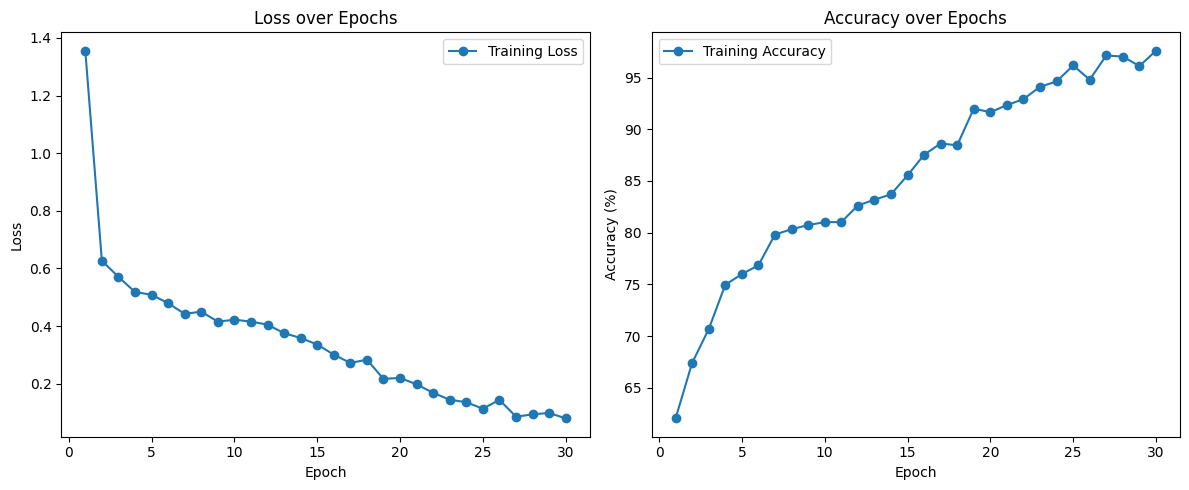

In [60]:
# Number of epochs and batch size
num_epochs = 30

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lists to store the loss and accuracy values for plotting
train_loss_history = []
train_accuracy_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Compute loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # Store the values for plotting
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)
    
    # Print epoch stats
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Plotting the Loss and Accuracy over epochs
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_history, marker='o', label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy_history, marker='o', label='Training Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [61]:
# Initialize empty lists to store true and predicted labels
all_labels = []
all_predictions = []

model.eval()  # Set model to evaluation mode (no gradients)
correct = 0
total = 0

with torch.no_grad():  # No need to compute gradients
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Accumulate total correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and true labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute test accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 85.27397260273973%
Confusion Matrix:
[[341  52]
 [ 34 157]]


In [62]:
# save the trained model
torch.save(model.state_dict(), "audio_classifier_cnn.pth")

In [22]:
final_df['water_drinking'].value_counts()

water_drinking
0    1803
1     530
Name: count, dtype: int64

In [26]:
def split_and_label_audio(audio, event_df, sr=16000, window_size=30, overlap=15):
    labeled_segments = []
    step = window_size - overlap  # Compute step size based on overlap
    
    # Iterate over each row in event_df
    for _, row in tqdm(event_df.iterrows()):
        # Convert start and end times from seconds to milliseconds
        start_time = row['start'] * 1000  # Start time in milliseconds
        end_time = row['end'] * 1000      #  time in milliseconds
        
        # Loop to create overlapping windows within each event
        while start_time < end_time:
            # Check if the drinking event is within the window
            label = 0  # Default label is 0 (no drinking)
            for idx, check_row in event_df.iterrows():
                if check_row['start'] * 1000 <= start_time < check_row['end'] * 1000:
                    label = 1  # Drinking event is in the window
                    break
            
            # Extract the audio segment based on the start and end time
            segment = audio[start_time:start_time + window_size * 1000]
            
            # Append the segment and its label
            labeled_segments.append((segment, label))
            
            # Move the window with overlap
            start_time += step * 1000  # Move by step size in milliseconds
    
    return labeled_segments

In [ ]:
audio_segments = split_and_label_audio(audio=final_audio, event_df=event_df, window_size=45, overlap=15)

all_mfccs = []
all_labels = []

for segment, label in tqdm(audio_segments):
    mfcc = extract_mfcc(segment)
    all_mfccs.append(mfcc)
    all_labels.append(label)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_mfccs, all_labels, test_size=0.25, random_state=42, stratify=all_labels)


In [67]:
from torch.utils.data import Dataset, DataLoader
import torch

class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        mfcc = self.X[idx]
        label = self.y[idx]
        mfcc = np.expand_dims(mfcc, axis=0)  # Add channel dimension
        return torch.tensor(mfcc, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [77]:
class DeepAudioClassifierCNN(nn.Module):
    def __init__(self):
        super(DeepAudioClassifierCNN, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.3)  # Regularization
        
        # Second Convolutional Block with Residual Connection
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv1x1_1 = nn.Conv2d(32, 64, kernel_size=1)  # Match residual channels
        self.dropout2 = nn.Dropout2d(0.3)
        
        # Third Convolutional Block with Residual Connection
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv1x1_2 = nn.Conv2d(64, 128, kernel_size=1)  # Match residual channels
        self.dropout3 = nn.Dropout2d(0.3)

        # Fully Connected Layers
        self.fc1 = nn.Linear(self._get_conv_output_size(), 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)  # Binary classification

    def _get_conv_output_size(self):
        # Create a dummy input to calculate the size after convolution layers
        dummy_input = torch.zeros(1, 1, 1876, 13)  # Adjust according to your MFCC input
        x = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Apply until last conv layer
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        return int(torch.prod(torch.tensor(x.size()[1:])))
    
    def forward(self, x):
        # First Convolutional Block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        # Second Convolutional Block with Residual Connection
        residual = self.conv1x1_1(x)  # Adjust residual channels to match conv output
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x + residual  # Replace in-place addition
        x = self.pool(x)
        x = self.dropout2(x)

        # Third Convolutional Block with Residual Connection
        residual = self.conv1x1_2(x)  # Adjust residual channels to match conv output
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = x + residual  # Replace in-place addition
        x = self.pool(x)
        x = self.dropout3(x)

        # Flatten for Fully Connected Layers
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for output, use CrossEntropyLoss

        return x

# Create the model instance
model = DeepAudioClassifierCNN()


In [78]:
# Define loss function (Cross-Entropy Loss for classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/30], Loss: 0.8349, Accuracy: 63.87%
Epoch [2/30], Loss: 0.6106, Accuracy: 66.21%
Epoch [3/30], Loss: 0.5668, Accuracy: 68.10%
Epoch [4/30], Loss: 0.5584, Accuracy: 71.18%
Epoch [5/30], Loss: 0.5017, Accuracy: 75.19%
Epoch [6/30], Loss: 0.4696, Accuracy: 79.30%
Epoch [7/30], Loss: 0.4439, Accuracy: 79.47%
Epoch [8/30], Loss: 0.4206, Accuracy: 80.67%
Epoch [9/30], Loss: 0.3857, Accuracy: 83.25%
Epoch [10/30], Loss: 0.3740, Accuracy: 83.59%
Epoch [11/30], Loss: 0.3544, Accuracy: 84.62%
Epoch [12/30], Loss: 0.3000, Accuracy: 87.02%
Epoch [13/30], Loss: 0.2792, Accuracy: 87.31%
Epoch [14/30], Loss: 0.2450, Accuracy: 89.71%
Epoch [15/30], Loss: 0.2176, Accuracy: 91.19%
Epoch [16/30], Loss: 0.2045, Accuracy: 92.11%
Epoch [17/30], Loss: 0.1330, Accuracy: 95.20%
Epoch [18/30], Loss: 0.1495, Accuracy: 93.14%
Epoch [19/30], Loss: 0.1225, Accuracy: 95.31%
Epoch [20/30], Loss: 0.1049, Accuracy: 96.23%
Epoch [21/30], Loss: 0.0914, Accuracy: 96.74%
Epoch [22/30], Loss: 0.0796, Accuracy: 96.9

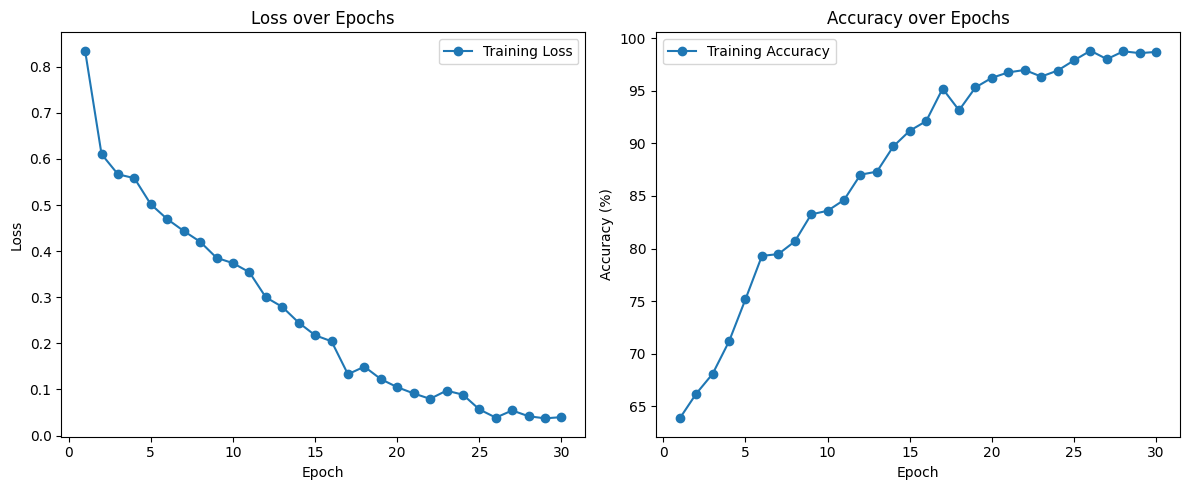

In [79]:
# Number of epochs and batch size
num_epochs = 30

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lists to store the loss and accuracy values for plotting
train_loss_history = []
train_accuracy_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Compute loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # Store the values for plotting
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)
    
    # Print epoch stats
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Plotting the Loss and Accuracy over epochs
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_history, marker='o', label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy_history, marker='o', label='Training Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [76]:
# Initialize empty lists to store true and predicted labels
all_labels = []
all_predictions = []

model.eval()  # Set model to evaluation mode (no gradients)
correct = 0
total = 0

with torch.no_grad():  # No need to compute gradients
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Accumulate total correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and true labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute test accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 84.76027397260275%
Confusion Matrix:
[[340  53]
 [ 36 155]]


In [1]:
    # 